
Welcome to this tutorial on installing and using the latest CorgiSim simulation tools. In this guide, we'll walk through how to set up and run simulations of an on-axis host star with off-axis companions for observations with the Roman Coronagraph Instrument (CGI).

 This tutorial is intended to help you get started quickly and to provide a clear overview of CorgiSim’s current infrastructure and workflow. It's especially geared toward those interested in contributing to the development and improvement of the code.


# Installation

Since **CorgiSim** is still under active development, we recommend cloning the **main** branch from the repository and installing it in **editable mode**. It's also best to work in a **virtual environment** to avoid conflicts with other packages.

## Step-by-step instructions

1. **Clone the repository:**


```
    git clone -b main https://github.com/roman-corgi/corgisim.git
    cd corgisim
```
2. **Install in editable mode:**

```
    pip install -e .
```

## Required dependencies
To install the required dependencies, run:
```
    pip install -r requirements.txt
```
This will install all Python packages available via `pip`, including `synphot`.  
For more information on `synphot`, refer to its [documentation](https://synphot.readthedocs.io/en/latest/#installation-and-setup).

> ⚠️ Note: Some packages must be installed manually because they are not available on PyPI:

- **cgisim**: [https://sourceforge.net/projects/cgisim/](https://sourceforge.net/projects/cgisim/)
- **roman_preflight**: [https://sourceforge.net/projects/cgisim/files/](https://sourceforge.net/projects/cgisim/files/)
- **PROPER**: [https://sourceforge.net/projects/proper-library/](https://sourceforge.net/projects/proper-library/)

Detailed installation instructions for the required dependencies can be found in the README of Corgisim github repo: https://github.com/roman-corgi/corgisim/tree/main?tab=readme-ov-file



# Run the first simulation


In [1]:
## import packages
from corgisim import scene
from corgisim import instrument
import matplotlib.pyplot as plt
import numpy as np
import proper
from corgisim import outputs

/opt/anaconda3/envs/CGISim/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Step 0: Copying a Prescription File

To get started, you'll need a Roman CGI prescription file in your working folder. The `roman_preflight_proper` package provides a helper function to copy a default prescription file into your current working directory.         

Note: If the file is already present, you can skip this step. However, you'll need to repeat it whenever you switch to a new working directory.



In [2]:
#First, import the module:
import roman_preflight_proper
### Then, run the following command to copy the default prescription file 
roman_preflight_proper.copy_here()

### Step 1: Define the Astrophysical Scene

Begin by specifying the astrophysical scene you want to simulate. This typically includes:

- A **host star**
- One or more **companions** (e.g., exoplanets or brown dwarfs)
- *(Future feature)* A 2D background scene, such as circumstellar disks — *not yet implemented*

> **Note:** As of now, only point sources (host stars and companions) are supported. 2D scene functionality will be added in future versions.

#### 🔹 Host Star

The following parameters are required for defining the host star:

1. **Spectral type** (e.g., `"G2V"`)
2. **V-band magnitude** (numeric value)
3. **Magnitude type** — currently, only **Vega magnitude** (`"vegamag"`) is supported

#### 🔹 Companions

You may define multiple companions. For each one, specify:

1. **V-band magnitude** brigtness of the companions  
2. **Magnitude type** — currently, only **Vega magnitude** (`"vegamag"`) is supported  
3. **position_x** — X-coordinate of the source position in milliarcseconds (mas), relative to the host star  
4. **position_y** — Y-coordinate of the source position in milliarcseconds (mas), relative to the host star  
For companion spectrum, currently, a flat spectrum will be generated based on the V-band magnitude

✅ Make sure to provide values in the expected format so the simulation can interpret the astrophysical inputs correctly.


In [3]:
# --- Host Star Properties ---
Vmag = 8                            # V-band magnitude of the host star
sptype = 'G0V'                      # Spectral type of the host star
host_star_properties = {'Vmag': Vmag,
                        'spectral_type': sptype,
                        'magtype': 'vegamag'}

# --- Companion Properties ---
# Define two companions
mag_companion = [25, 25]           # List of magnitudes for each companion

# Define their positions relative to the host star, in milliarcseconds (mas)
# For reference: 1 λ/D at 550 nm with a 2.3 m telescope is ~49.3 mas
# We're placing them at a separation of 3 λ/D
dx = [3 * 49.3, -3 * 49.3]         # X positions in mas for each companion
dy = [3 * 49.3, -3 * 49.3]         # Y positions in mas for each companion

# Construct a list of dictionaries for all companion point sources
point_source_info = [
    {
        'Vmag': mag_companion[0],
        'magtype': 'vegamag',
        'position_x': dx[0],
        'position_y': dy[0]
    },
    {
        'Vmag': mag_companion[1],
        'magtype': 'vegamag',
        'position_x': dx[1],
        'position_y': dy[1]
    }
]

# --- Create the Astrophysical Scene ---
# This Scene object combines the host star and companion(s)
base_scene = scene.Scene(host_star_properties, point_source_info)

# --- Access the generated stellar spectrum ---
sp_star = base_scene.stellar_spectrum
# --- Access the generated companion spectrum ---
sp_comp = base_scene.off_axis_source_spectrum 


Adding 2 off-axis sources


The output of ```base_scene.stellar_spectrum``` is a ```SourceSpectrum``` object from ```synphot``` package. Details see https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SourceSpectrum.html#synphot.spectrum.SourceSpectrum

The output of ```base_scene.off_axis_source_spectrum```  is a list of ```SourceSpectrum``` object,  each corresponding to an input companion.

The default unit for wavelength is **Angstrom**, and the default unit for flux density is **photlam** (photons/s/cm^2/Angstrom). For units in ```synphot``` see: https://synphot.readthedocs.io/en/latest/synphot/units.html#synphot-flux-units

Let's plot the stellar spectrum to have a look. Currently, we only have blackbody spectrum, but will add more complated ones in future.


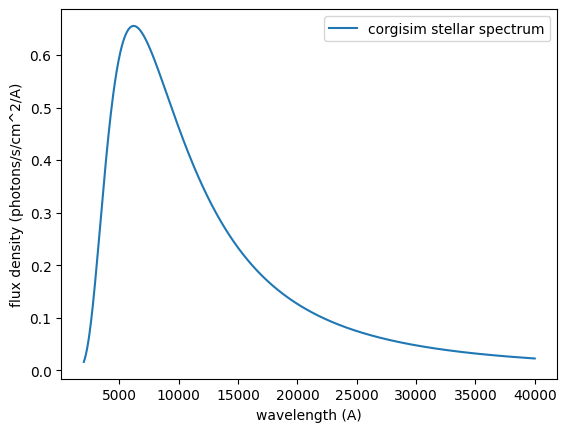

In [4]:
ax=plt.subplot(111)
#sp.plot(ax=ax)
lambd = np.linspace(2000, 40000, 1000)
ax.plot(lambd , sp_star(lambd  ).value,label='corgisim stellar spectrum')
ax.set_xlabel('wavelength (A)')
ax.set_ylabel('flux density (photons/s/cm^2/A)')
plt.legend()

Let's then plot the spectrum of the first companion. Since we didn't provide a custom spectrum, it uses the default flat spectrum automatically generated based on its V-band magnitude.

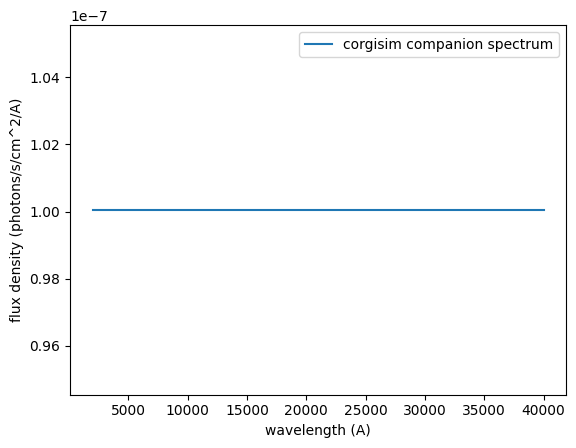

In [5]:
ax=plt.subplot(111)
#sp.plot(ax=ax)
lambd = np.linspace(2000, 40000, 1000)
ax.plot(lambd , sp_comp[0](lambd  ).value,label='corgisim companion spectrum')
ax.set_xlabel('wavelength (A)')
ax.set_ylabel('flux density (photons/s/cm^2/A)')
plt.legend()

#### Step 2: now you need to define the parameters for the telescope and instrument

The simulation mode is inherited from cgisim. In general, there are three supported modes, though currently only excam is implemented.

In [6]:
# Simulation mode (currently only 'excam' is implemented)
# Options include:
#   - 'excam': direct imaging mode (returns intensity image)
#   - 'spec': spectral mode using the "spc-spec" coronagraph
#   - 'excam_efield': like 'excam', but returns electric field across wavelengths instead of intensity
cgi_mode = 'excam'


Choose the coronagraph type to use in the simulation. As of now, only hlc is implemented.

In [7]:
# Coronagraph type
# Options (availability depends on implementation status):
#   - 'hlc', 'hlc_band1', 'hlc_band2', 'hlc_band3', 'hlc_band4'
#   - 'spc-spec_band2', 'spc-spec_band3'
#   - 'spc-wide_band1', 'spc-wide_band4'
#   - 'spc-mswc_band1', 'spc-mswc_band4'

cor_type = 'hlc'



Set bandpass filter to use with the selected coronagraph. The available options depend on the chosen **cor_type**.  
For example, if using `'hlc'` or `'hlc_band1'`, valid bandpasses include: `'1'`, `'1a'`, `'1b'`, `'1c'`, `'1_all'`.  
Refer to the table below for the valid bandpasses corresponding to each **cor_type**, as well as the definitions of the bandpasses. For more details on available bandpasses and how they’re defined, see the cgisim documentation: **cgisim_public_v4.0.pdf** You can donwload the cgisim_v4.0.zip from https://sourceforge.net/projects/cgisim/files/. The ZIP archive includes the documentation file.


| **cor_type**                                               | **Allowed Bandpasses**                                  |
|------------------------------------------------------------|----------------------------------------------------------|
| hlc or hlc_band1                                           | 1, 1a, 1b, 1c, 1_all                                     |
| hlc_band2                                                  | 2, 2a, 2b, 2c, 3a, 3b                                   |
| hlc_band3                                                  | 3, 3a, 3b, 3c, 3d, 3e, 3g                               |
| hlc_band4                                                  | 4, 4a, 4b, 4c                                           |
| spc-spec_band2                                             | 2, 2a, 2b, 2c, 3a, 3b                                   |
| spc-spec_band2_rotated                                     | 2, 2a, 2b, 2c, 3a, 3b                                   |
| spc-spec or spc-spec_band3                                 | 3, 3a, 3b, 3c, 3d, 3e, 3g                               |
| spc-spec_rotated or spec-spec_band3_rotated               | 3, 3a, 3b, 3c, 3d, 3e, 3g                               |
| spc-wide_band1                                             | 1, 1a, 1b, 1c                                           |
| spc-wide or spc-wide_band4                                 | 4, 4a, 4b, 4c                                           |
| spc-mswc_band1                                             | 1, 1a, 1b, 1c                                           |
| spc-mswc or spc-mswc_band4                                 | 4, 4a, 4b, 4c                                           |


| Bandpass Name | Central Wavelength λ<sub>c</sub> | FWHM Bandwidth Δλ/λ<sub>c</sub> |
|---------------|-------------------------------|------------------------------|
| 1             | 575 nm                        | 10.1 %                       |
| 1a            | 556 nm                        | 3.5 %                        |
| 1b            | 575 nm                        | 3.3 %                        |
| 1c            | 594 nm                        | 3.2 %                        |
| 2             | 660 nm                        | 17.0 %                       |
| 2a            | 615 nm                        | 3.6 %                        |
| 2b            | 638 nm                        | 2.8 %                        |
| 2c            | 656 nm                        | 1.0 %                        |
| 3             | 730 nm                        | 16.7 %                       |
| 3a            | 681 nm                        | 3.5 %                        |
| 3b            | 704 nm                        | 3.4 %                        |
| 3c            | 727 nm                        | 2.8 %                        |
| 3g            | 752 nm                        | 3.4 %                        |
| 3d            | 754 nm                        | 1.0 %                        |
| 3e            | 778 nm                        | 3.5 %                        |
| 4             | 825 nm                        | 11.4 %                       |
| 4a            | 792 nm                        | 3.5 %                        |
| 4b            | 825 nm                        | 3.6 %                        |
| 4c            | 857 nm                        | 3.5 %                        |


In [8]:
bandpass = '1'

Load a Pre-Saved DM File. Several pre-generated deformable mirror (DM) files are available for different coronagraph types and contrast configurations. The DM solution files are stored in the  ```examples ``` folder of  ```roman_preflight_proper ```

Available configurations:
- HLC:
    hlc_ni_2e-9, hlc_ni_3e-8, hlc_ni_5e-9

- SPC-Spec:
    spc-spec_ni_1e-9, spc-spec_ni_2e-8, spc-spec_ni_4e-9

- SPC-Wide:
    spc-wide_ni_2e-8, spc-wide_ni_3e-9, spc-wide_ni_5e-9

In [9]:

cases = ['3e-8']       
rootname = 'hlc_ni_' + cases[0]
dm1 = proper.prop_fits_read( roman_preflight_proper.lib_dir + '/examples/'+rootname+'_dm1_v.fits' )
dm2 = proper.prop_fits_read( roman_preflight_proper.lib_dir + '/examples/'+rootname+'_dm2_v.fits' )


In [11]:
##  Define the polaxis parameter. Use 10 for non-polaxis cases only, as other options are not yet implemented.
polaxis = 10
# output_dim define the size of the output image
output_dim = 51

### define a dictinatary to pass keywarod to proper
### proper_keywords are the keyword arguments to the internal functions for package proper, which define the optics of coronagraph
# use_dm1/use_dm2: if use dm
# use_fpm: if use focal plane mask
# use_lyot_stop: if use lyot stop 
# use_field_stop: if use field stop
# other paramters that could pass to Proper defined by CgiSim

proper_keywords ={'cor_type':cor_type, 'use_errors':2, 'polaxis':polaxis, 'output_dim':output_dim,\
                    'use_dm1':1, 'dm1_v':dm1, 'use_dm2':1, 'dm2_v':dm2,'use_fpm':1, 'use_lyot_stop':1,  'use_field_stop':1 }

##define the corgi.optics class that hold all information about the instrument paramters                    
optics = instrument.CorgiOptics(cgi_mode, bandpass, proper_keywords=proper_keywords, if_quiet=True)

CorgiOptics initialized with proper keywords.


Now let's plot the filter curve. 
Note that you don’t need to set up the bandpass manually when running CorgiSim — ```corgisim.optics``` will automatically select the appropriate bandpass based on the input filter number. The following is for illustration purposes only.

the output of ```optics.setup_bandpass``` is ```SpectralElement``` object from ```synphot```, details see https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SpectralElement.html#synphot.spectrum.SpectralElement

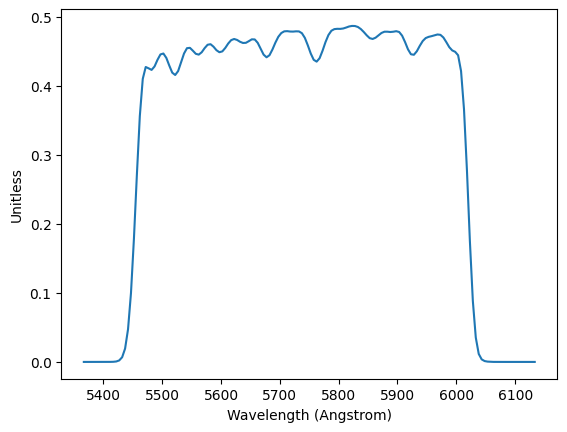

In [12]:
nd_filter = 0
bp = optics.setup_bandpass(cgi_mode, bandpass, nd_filter )
bp.plot()

### 💡 Tip for Delevoper

If you want to integrate the stellar flux over a given bandpass, you can use the `Observation` class from `synphot`. This allows you to compute the photon count rate through a filter while accounting for the filter transmission curve. Below is an example of how to calculate the integrated photon counts for the stellar spectrum after applying a defined bandpass **bp** from the previous steps.


> ⚠️ You **do not** need to do this step manually for running corgisim.  
> This example is only meant to demonstrate how `corgisim` performs bandpass integration internally.



In [13]:
from synphot import  Observation
# Compute the observed stellar spectrum within the defined bandpass
# obs: wavelegth is in unit of angstrom
# obs: flux is in unit of photons/s/cm^2/angstrom
obs = Observation(base_scene.stellar_spectrum, bp)
#obs.plot()

area = 35895.212    # primary effective area for Roman from cgisim in cm^2
# Compute total photon counts integrated across the full bandpass
counts = obs.countrate(area=area)
print('Total counts across the bandpass:',counts)
## you can also integrate across a narrower wavelength range within the bandpass
counts_sub = obs.countrate(area=area,  waverange=[5700, 5800])
print('Total counts from 5700-5800 A:',counts_sub)

Total counts across the bandpass: 6055798.844333797 ct / s
Total counts from 5700-5800 A: 1089517.136934274 ct / s


### Step 3: Generate the PSF for the on-axis star and inject companions

The `get_psf` function from the `CorgiOptics` class generates the on-axis PSF for the host star. It takes the following inputs:

- **input_scene**: A `corgisim.scene.Scene` object that defines the properties of the host star to be simulated.
- **sim_scene** *(optional)*: A `corgisim.SimulatedScene` object that stores the simulated scene.  
  If `None`, the function will generate a new `SimulatedScene` object as output.  
  If provided, the function will update the existing `sim_scene` with the simulated image of on-axis host star psf.

The output is an Astropy HDU containing the simulated image, with header comments detailing the input host star properties and simulation setup.



In [14]:
## Pass the base_scene object to corgi.optics and use get_psf to simulate the host star PSF.
## The result is stored in a SimulatedScene object as an Astropy HDU containing both data and header information.

sim_scene = optics.get_host_star_psf(base_scene)
image_star_corgi = sim_scene.host_star_image.data



Next, you can generate the image of the off-axis point sources and inject it into the PSF image.

The `inject_point_sources` function from the `CorgiOptics` class injects point sources into the scene.. It takes the following inputs:

- **input_scene**: A `corgisim.scene.Scene` object that include a list of the companions to be simulated.
- **sim_scene** *(optional)*: A `corgisim.SimulatedScene` object that stores the simulated scene.  
  If `None`, the function will generate a new `SimulatedScene` object as output.  
  If provided, the function will update the existing `sim_scene` with the simulated image of off-axis-companions.

The output is an Astropy HDU containing the simulated image, with header comments detailing the input  companion properties and simulation setup.



In [15]:
## Pass base_scene and optionally sim_scene to corgi.optics to inject off-axis sources.
## The result is returned as a SimulatedScene object with an Astropy HDU containing both data and header information.


sim_scene = optics.inject_point_sources(base_scene,sim_scene)
image_comp_corgi = sim_scene.point_source_image.data 
combined_image_corgi = image_star_corgi + image_comp_corgi

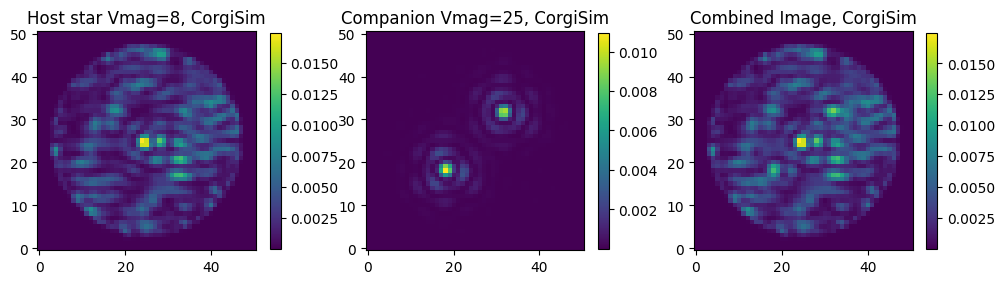

In [16]:
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(image_star_corgi,origin='lower')
plt.title('Host star Vmag=8, CorgiSim')

co = plt.colorbar(shrink=0.7)
plt.subplot(132)
plt.imshow(image_comp_corgi,origin='lower')
plt.title('Companion Vmag=25, CorgiSim')

co = plt.colorbar(shrink=0.7)

plt.subplot(133)
plt.imshow(combined_image_corgi,origin='lower')
plt.title('Combined Image, CorgiSim')

co = plt.colorbar(shrink=0.7)

### Step 4: Simulate the Image on the Detector

So far, we've simulated images of a host star with two companions using Roman-CGI. However, we haven't yet included detector noise! In this step, we'll define a **`corgi.Detector`** object to add detector effects to the simulation.

The `emccd_keywords` dictionary is passed to `instrument.CorgiDetector` to configure the EMCCD detector. It includes the following parameters:

- **em_gain**: Electron multiplication gain. Default is `1000`.
- **full_well_image**: Full well capacity for the image section. Requirement: `50,000`; CBE: `60,000`.
- **full_well_serial**: Full well capacity for the serial register. Requirement: `90,000`; CBE: `100,000`.
- **dark_rate**: Dark current rate in e⁻/pix/s. Requirement: `1.0`; CBE: `0.00042` (0 yrs) / `0.00056` (5 yrs).
- **cic_noise**: Clock-induced charge noise in e⁻/pix/frame. Default: `0.01`.
- **read_noise**: Read noise in e⁻/pix/frame. Requirement: `125`; CBE: `100`.
- **bias**: Bias level in digital numbers (DN). Default: `0`.
- **qe**: Quantum efficiency. Set to `1.0` here, since it's already factored into the photon counts.
- **cr_rate**: Cosmic ray event rate in hits/cm²/s. Use `0` for no cosmic rays, `5` for L2 environment.
- **pixel_pitch**: Pixel pitch in meters. Default: `13e-6`.
- **e_per_dn**: Electrons per data unit after multiplication.
- **numel_gain_register**: Number of elements in the gain register. Default: `604`.
- **nbits**: Number of bits in the ADC (analog-to-digital converter). Default: `14`.
- **use_traps**: Whether to simulate CTI effects using trap models. Default: `False`.
- **date4traps**: Decimal year of observation. Only used if `use_traps=True`. Default: `2028.0`.


In [17]:

### emccd_keywords are the keyword arguments to the internal functions for  emccd_detect,
###  and that everything stays the default settings unless otherwise changed.
### In this example, we'll use the default parameters for the EMCCD detector, except for the EM gain.

gain =100
emccd_keywords ={'em_gain':gain}
detector = instrument.CorgiDetector(emccd_keywords)



The `generate_detector_image` function from the `CorgiDetector` class generates a detector image from the simulated input scene. It takes the following arguments:

- **simulated_scene**: A `corgisim.scene.SimulatedScene` object that contains the noise-free scene from CorgiOptics
- **exptime**: Exposure time in seconds.
- **full_frame** *(bool)*: If `True`, generates a full-frame detector image and places the sub-frame within it.
- **loc_x** *(int)*: Horizontal (x) pixel coordinate of the center where the sub-frame will be inserted. Required if `full_frame=True`.
- **loc_y** *(int)*: Vertical (y) pixel coordinate of the center where the sub-frame will be inserted. Required if `full_frame=True`.

For subframe simulation (**full_frame==False**), the output is an Astropy HDU containing the simulated image, with header comments detailing the inputs and simulation setup.

For fullframe simulation (**full_frame==True**), the output is an Astropy HDUList containing a simulated image with appropriate headers, including:
- The primary HDU contains a global header (without image data).
- The image HDU contains the 2D image array and its own header.


In [18]:

#In real observations, exposures are typically broken into a sequence of short frames (e.g., 100s per frame) to reduce the impact of cosmic ray hits.
#However, for simplicity in this example, we'll simulate a single long exposure (10000s) here.
exptime = 10000
sim_scene = detector.generate_detector_image(sim_scene,exptime)
image_tot_corgi_sub= sim_scene.image_on_detector.data

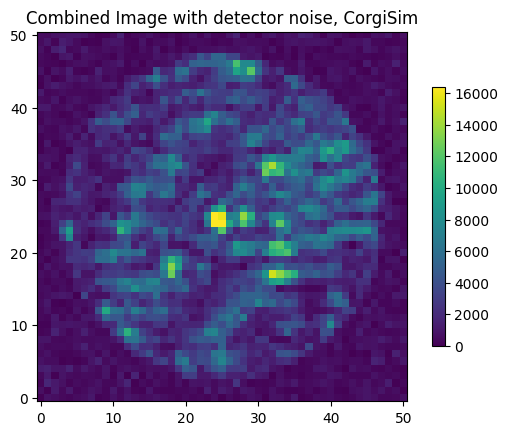

In [19]:
plt.imshow(image_tot_corgi_sub,origin='lower')
plt.title('Combined Image with detector noise, CorgiSim')

co = plt.colorbar(shrink=0.7)

We're not done yet! To complete the simulation, we need to generate a **Level 1 (L1) data product** — a full-frame EMCCD image.

This requires placing the subframe we just simulated onto the full Roman EMCCD frame.  
You can do this by setting the keyword `full_frame=True` in the detector call.

- `loc_x` and `loc_y` specify the center position (in pixels) where the subframe should be placed on the full EMCCD frame.


In [20]:

sim_scene = detector.generate_detector_image(sim_scene,exptime,full_frame=True,loc_x=300, loc_y=300)
image_tot_corgi_full = sim_scene.image_on_detector[1].data

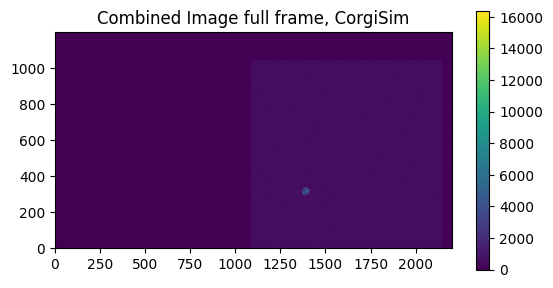

In [21]:
plt.imshow(image_tot_corgi_full,origin='lower')
plt.title('Combined Image full frame, CorgiSim')

co = plt.colorbar(shrink=0.7)

Now, let's save the simulated images as FITS files using the function ``` .save_hdu_to_fits()``` from ```outputs.py```. 
This function accepts the following inputs:
- hdul (astropy.io.fits.HDUList): The HDUList object to be saved.
- outdir (str, optional): Output directory. Defaults to the current working directory.
- overwrite (bool): If True, overwrite the file if it already exists. Default is True.
- write_as_L1 (bool): If True, it will save final L1 product, the file will be named according to the L1 naming convention. 
- filename (str, optional): Name of the output FITS file (without ".fits" extension). 
                            Required if write_as_L1 is False.

The function can save two types of FITS products:

- When ``write_as_L1=True``, it saves a final L1 product with an automatically generated filename following the L1 naming convention.
The header follows the formal L1 structure from corgidrp, and additional simulation-specific comments are added to the primary HDU to track the simulation setup.

- When ``write_as_L1=False``, it saves intermediate products (e.g., **host_star_image**, **point_source_image**).
In this case, you must manually provide a filename, and the header will not strictly adhere to the default DRP L1 format.

In [21]:
##you can set your output path here
## If outdir is None, the output fits files will be saved in the current working directory.
outdir = None
### save intemediate products
outputs.save_hdu_to_fits(sim_scene.host_star_image, outdir = outdir, filename='host_star_image', write_as_L1=False)

### save final L1 producr
outputs.save_hdu_to_fits(sim_scene.image_on_detector, outdir = outdir, write_as_L1=True)
   


Saved FITS file to: /Users/jingwenzhang/Desktop/corgisim/examples/host_star_image.fits
Saved FITS file to: /Users/jingwenzhang/Desktop/corgisim/examples/CGI_0000000000000000000_20250501T2001273_L1_.fits
